# 소년_일반_범죄자_처분비교
> 소년 범죄자와 일반 범죄자의 처분결과 비교

- 처음 생각은 형량 데이터를 비교하면 좋겠다고 생각했지만 사용 데이터에 해당 내용은 없음
- 확보한 데이터에 있는 항목을 기준으로 직관적으로 비교 가능한 방법은 기소율 이라고 판단하여 범죄 분류별로 기소율을 비교하기로 함

In [1]:
# 라이브러리 import
import pandas as pd
import pymysql

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# db 접속정보 설정
DB_HOST = 'ec2-54-180-162-177.ap-northeast-2.compute.amazonaws.com'
DB_PORT = 3306
DB_USER = 'hotsix'
DB_PASS = ''
DB_NAME = 'hotsix'

In [3]:
# db 접속
conn = pymysql.connect(host = DB_HOST, port = DB_PORT, user = DB_USER, passwd = DB_PASS, db = DB_NAME)
cur = conn.cursor()


# 범죄자 처분 결과(전체) 테이블 생성
sql = "DROP TABLE IF EXISTS disposal_result_all"
cur.execute(sql)

sql = """
CREATE TABLE disposal_result_all
(
    `id`             INT             NOT NULL    AUTO_INCREMENT COMMENT 'ID', 
    `category`       VARCHAR(100)    NULL        COMMENT '범죄분류', 
    `indictment`     INT             NULL        COMMENT '기소', 
    `nonindictment`  INT             NULL        COMMENT '불기소', 
     PRIMARY KEY (id)
);
"""
cur.execute(sql)

# 범죄자 처분 결과(전체) 테이블 생성
sql = "DROP TABLE IF EXISTS disposal_result_young"
cur.execute(sql)

sql = """
CREATE TABLE disposal_result_young
(
    `id`             INT             NOT NULL    AUTO_INCREMENT COMMENT 'ID', 
    `category`       VARCHAR(100)    NULL        COMMENT '범죄분류', 
    `indictment`     INT             NULL        COMMENT '기소', 
    `nonindictment`  INT             NULL        COMMENT '불기소', 
     PRIMARY KEY (id)
);
"""
cur.execute(sql)

# db 연결 종료
conn.close()

In [4]:
# 전체 범죄자 처분 데이터 로딩
df = pd.read_csv('./Data/05_소년범죄자와 성인 범죄자 처분결과 비교_윤재철_1.csv', encoding='cp949')
df.head()

,No,자료시점,분류,분류.1,분류.2,분류.3,계,계.1,계.2,계.3,...,계.7,계.8,계.9,계.10,계.11,계.12,계.13,계.14,계.15,계.16
0,No,자료시점,분류,분류,분류,분류,계,기소(소계),기소(소계),기소(소계),...,성매매보호송치,아동보호송치,불기소(소계),불기소(소계),불기소(소계),불기소(소계),불기소(소계),기소중지,참고인중지,공소보류
1,No,자료시점,분류,분류,분류,분류,계,기소(소계),구공판 구속,구공판 불구속,...,성매매보호송치,아동보호송치,불기소(소계),기소유예,혐의없음,죄가안됨,공소권없음,기소중지,참고인중지,공소보류
2,No,자료시점,분류,분류,분류,분류,원자료,원자료,원자료,원자료,...,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료
3,1,2018년,계,계[입력치],계[입력치],계[입력치],"1,755,435","704,758","26,021","160,150",...,459,"2,782","893,943","268,731","293,558","3,666","327,988","104,930","5,430",0
4,2,2018년,형법범,형법범계[입력치],형법범계[입력치],형법범계[입력치],"958,949","286,161","19,759","98,863",...,3,372,"552,628","181,775","212,361","3,382","155,110","75,967","4,345",0


In [5]:
# 각 분류 별 계 항목 제거
df = df[(df['분류'] != '분류') & (df['분류'] != '계') & (~df['분류.1'].str.contains('계')) & (~df['분류.2'].str.contains('계')) & (~df['분류.3'].str.contains('계'))]

# 기소, 불기소 데이터만 분류에 따라 조합
df_all = pd.DataFrame(data= { '분류': df['분류.1'], '일반 기소': df['계.1'], '일반 불기소': df['계.9'] })

# 기소, 불기소 문자열 -> 숫자로 변경
df_all['일반 기소'] = df_all['일반 기소'].str.replace(',', '').astype(int)
df_all['일반 불기소'] = df_all['일반 불기소'].str.replace(',', '').astype(int)

df_all.head()

,분류,일반 기소,일반 불기소
7,재산범죄,123,357
8,재산범죄,30688,53472
9,재산범죄,1899,889
11,재산범죄,2418,3091
12,재산범죄,9,51


In [6]:
data = []

for i in range(len(df_all)):

    
    indictment = df_all.iloc[i]['일반 기소']
    nonindictment = df_all.iloc[i]['일반 불기소']

    if indictment == 0 and nonindictment == 0:
        continue

    category = df_all.iloc[i]['분류']
    data.append([category, indictment, nonindictment])

print(data[0])

['재산범죄', 123, 357]


In [7]:
# 범죄자 처분 결과 데이터 등록
sql = """
INSERT INTO disposal_result_all(category, indictment, nonindictment)
VALUES (%s, %s, %s)
# """

# db 접속
conn = pymysql.connect(host = DB_HOST, port = DB_PORT, user = DB_USER, passwd = DB_PASS, db = DB_NAME)
cur = conn.cursor()

cur.executemany(sql, data)

# db 연결 종료
conn.commit()    
conn.close()

In [12]:
# 소년 범죄자 처분 데이터 로딩
df2 = pd.read_csv('./Data/05_소년범죄자와 성인 범죄자 처분결과 비교_윤재철_2.csv', encoding='cp949')
df2.head()

,No,자료시점,분류,분류.1,분류.2,계,계.1,계.2,계.3,계.4,...,계.7,계.8,계.9,계.10,계.11,계.12,계.13,계.14,계.15,계.16
0,No,자료시점,분류,분류,분류,계,기소(소계),기소(소계),기소(소계),기소(소계),...,성매매보호송치,아동보호송치,불기소(소계),불기소(소계),불기소(소계),불기소(소계),불기소(소계),기소중지,참고인중지,공소보류
1,No,자료시점,분류,분류,분류,계,기소(소계),구공판 구속,구공판 불구속,구약식,...,성매매보호송치,아동보호송치,불기소(소계),기소유예,혐의없음,죄가안됨,공소권없음,기소중지,참고인중지,공소보류
2,No,자료시점,분류,분류,분류,원자료,원자료,원자료,원자료,원자료,...,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료,원자료
3,1,2018년,계,계[입력치],계[입력치],"52,278","6,168",728,"3,222","2,218",...,0,3,"25,964","15,939","4,255",126,"5,644",337,27,0
4,2,2018년,형법범,형법범계[입력치],형법범계[입력치],"42,525","5,024",674,"2,907","1,443",...,0,2,"20,521","12,286","3,704",120,"4,411",258,24,0


In [13]:
# 각 분류 별 계 항목 제거
df2 = df2[(df2['분류'] != '분류') & (df2['분류'] != '계') & (~df2['분류.1'].str.contains('계')) & (~df2['분류.2'].str.contains('계'))]

# 기소, 불기소 데이터만 분류에 따라 조합
df_young = pd.DataFrame(data= { '분류': df2['분류.1'], '소년 기소': df2['계.1'], '소년 불기소': df2['계.9'] })

# 기소, 불기소 문자열 -> 숫자로 변경
df_young['소년 기소'] = df_young['소년 기소'].str.replace(',', '').astype(float)
df_young['소년 불기소'] = df_young['소년 불기소'].str.replace(',', '').astype(float)

df_young.head()

,분류,소년 기소,소년 불기소
6,재산범죄,1.0,1.0
7,재산범죄,1222.0,2033.0
8,재산범죄,69.0,501.0
9,재산범죄,11.0,123.0
10,재산범죄,1520.0,5910.0


In [14]:
data = []

for i in range(len(df_young)):

    indictment = df_young.iloc[i]['소년 기소']
    nonindictment = df_young.iloc[i]['소년 불기소']

    if indictment == 0 and nonindictment == 0:
        continue

    category = df_young.iloc[i]['분류']
    data.append([category, indictment, nonindictment])

print(data[0])

['재산범죄', 1.0, 1.0]


In [16]:
# 범죄자 처분 결과 데이터 등록
sql = """
INSERT INTO disposal_result_young(category, indictment, nonindictment)
VALUES (%s, %s, %s)
# """

# db 접속
conn = pymysql.connect(host = DB_HOST, port = DB_PORT, user = DB_USER, passwd = DB_PASS, db = DB_NAME)
cur = conn.cursor()

cur.executemany(sql, data)

# db 연결 종료
conn.commit()    
conn.close()

## 쿼리로 데이터 정리하여 테이블 생성
```mysql
create table disposal_result_all_group as          
select category, 
       sum(indictment) as indictment,
       sum(nonindictment) as nonindictment
  from disposal_result_all
 group by category 
 ```


 ```mysql
create table disposal_result_young_group as          
select category,
       sum(indictment) as indictment,
       sum(nonindictment) as nonindictment
  from disposal_result_young
 group by category 
 ```


 ```mysql
 create table disposal_result_merge as
select a.category,
       a.indictment - ifnull(b.indictment, 0) as indictment_all,
       a.nonindictment - ifnull(b.nonindictment, 0) as nonindictment_all,
       ifnull(b.indictment, 0) as indictment_young,
       ifnull(b.nonindictment, 0) as nonindictment_young
  from disposal_result_all_group a
  join disposal_result_young_group b
    on a.category = b.category    
```


```mysql
create table disposal_result_rate as
select category, 
       indictment_all,
       nonindictment_all,
       (indictment_all / (indictment_all + nonindictment_all)) * 100 AS rate_all,
       indictment_young ,
       nonindictment_young ,
       (indictment_young / (indictment_young + nonindictment_young)) * 100 AS rate_young
  from disposal_result_merge
```

In [18]:
# 비율 데이터 가져오기
# db 접속
conn = pymysql.connect(host = DB_HOST, port = DB_PORT, user = DB_USER, passwd = DB_PASS, db = DB_NAME, cursorclass=pymysql.cursors.DictCursor)
cur = conn.cursor()

sql = """
    SELECT category, '일반' as rate_type, rate_all as rate
      FROM disposal_result_rate
     UNION ALL
    SELECT category, '소년' as rate_type, rate_young as rate
      FROM disposal_result_rate
     ORDER BY category 
"""
cur.execute(sql)

result = cur.fetchall()
df_rate = pd.DataFrame(result)

# db 연결 종료
conn.commit()    
conn.close()

In [19]:
df_rate

,category,rate_type,rate
0,강력범죄(폭력),일반,30.0828
1,강력범죄(폭력),소년,13.5948
2,강력범죄(흉악),일반,53.0997
3,강력범죄(흉악),소년,34.3070
4,개인정보보호법,소년,0.0000
...,...,...,...
71,출입국관리법,소년,0.0000
72,특가법(도주차량),일반,61.2208
73,특가법(도주차량),소년,29.7297
74,풍속범죄,일반,46.9494


In [20]:
# 그래프 그리기

fm = mp.font_manager.FontManager()
#한글 지원하는 폰트명으로 재할당
plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rc('font', family='Malgun Gothic')

<AxesSubplot:xlabel='category', ylabel='rate'>

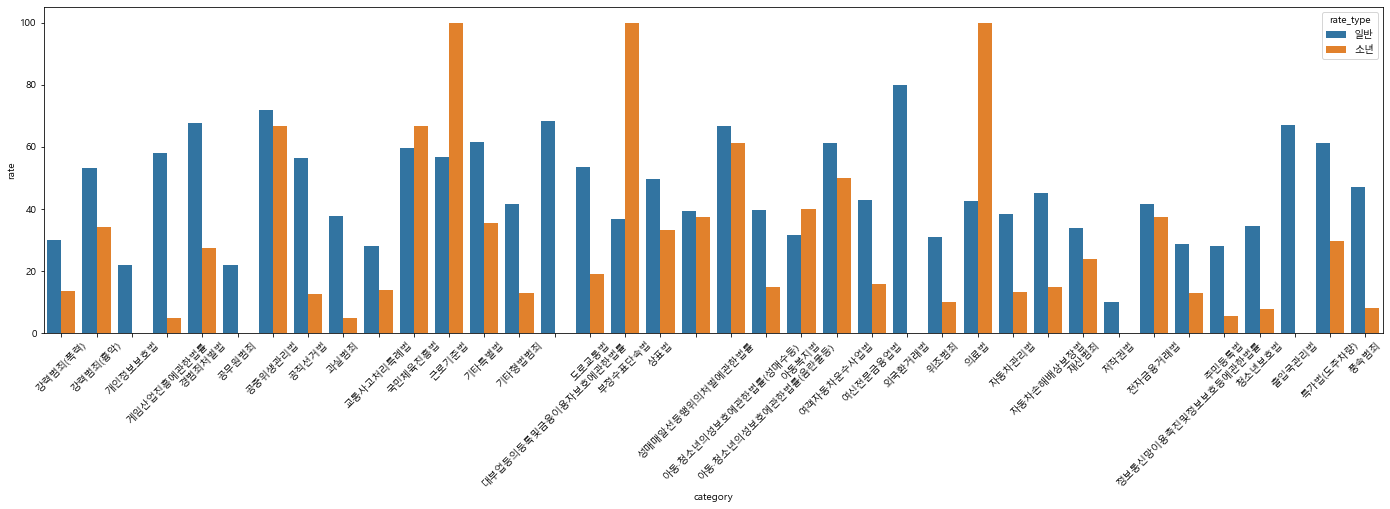

In [21]:
plt.figure(figsize=(24,6))
plt.xticks(rotation=45)
sns.barplot(data= df_rate, x='category',y ='rate', hue='rate_type')

# 문제점

- 전체 사건 대비 몇건이나 기소가 되었는지(재판에 회부되었는지) 단순비교
- 기소/불기소 여부는 사건의 경중을 더 따져야 하는 문제이기 때문에 기소율만으로 일반 범죄자와 소년범죄자의 차이를 비교할 수는 없음

In [43]:
# 비율 데이터 가져오기
# db 접속
conn = pymysql.connect(host = DB_HOST, port = DB_PORT, user = DB_USER, passwd = DB_PASS, db = DB_NAME, cursorclass=pymysql.cursors.DictCursor)
cur = conn.cursor()

sql = """
select  
        '기소율' as rate_type,
       (sum(indictment_all) / (sum(indictment_all) + sum(nonindictment_all))) * 100 AS rate_all,
        (sum(indictment_young) / (sum(indictment_young) + sum(nonindictment_young))) * 100 AS rate_young
  from disposal_result_merge
"""
cur.execute(sql)

result = cur.fetchall()
df_rate_all = pd.DataFrame(result)

# db 연결 종료
conn.commit()    
conn.close()

In [44]:
df_rate_all['rate_all'] = df_rate_all['rate_all'].astype(float)
df_rate_all['rate_young'] = df_rate_all['rate_young'].astype(float)
df_rate_all.columns = ['기소율', '성인 기소율', '소년 기소율']
df_rate_all = df_rate_all.melt('기소율')
df_rate_all.columns = ['rate_type', '구분', '기소율']
df_rate_all

,rate_type,구분,기소율
0,기소율,성인 기소율,36.3796
1,기소율,소년 기소율,19.1916


<AxesSubplot:xlabel='구분', ylabel='기소율'>

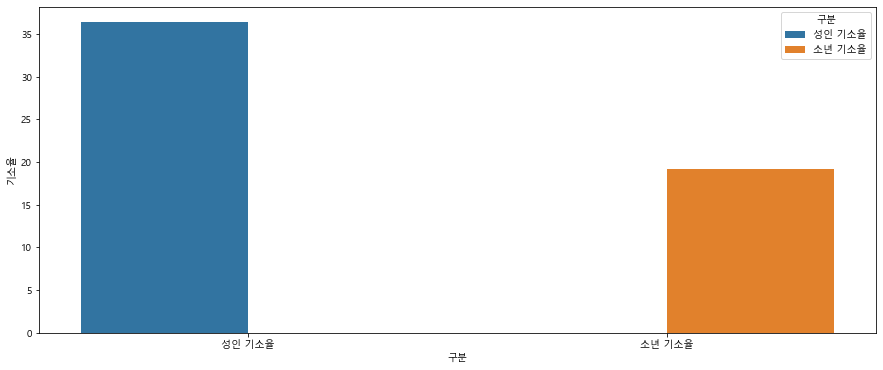

In [48]:
plt.figure(figsize=(15,6))
sns.barplot(data= df_rate_all, x='구분',y ='기소율', hue='구분')